In [95]:
import nibabel as nib
import numpy as np
import matplotlib.pylab as plt
import sys
import scipy.optimize as spopt
import scipy.fftpack as spfft
import scipy.ndimage as spimg
import cvxpy as cvx
import plotly.express as px
import plotly.offline as py
import plotly.graph_objects as go
import plotly.io as pio
import seaborn as sns
sys.path.append('../src/')

# custom scripts
import mri_cs
from visualization import plot_batch
from helpers import get_fourier_transform
from spiraltrajectory import spiral_samples_trajectory, kspace_measurements_spiral, minimum_energy_reconstruction
# from mri_cs import lpminimization, hermitian

from tqdm import tqdm
from nfft import nfft, ndft
from matplotlib.colors import LogNorm
from numpy.fft import fft2, fftshift
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

layout = go.Layout(template="plotly_dark")
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

py.init_notebook_mode()

In [9]:
IMG_PATH = '../data/scanVisit__0003__0003/MRI__0001/t2/Native/Original__0001/NIFTI/f0001.img'
HEADER_PATH = '../data/scanVisit__0003__0003/MRI__0001/t2/Native/Original__0001/NIFTI/f0001.hdr'

imgs = nib.load(IMG_PATH)
data = imgs.get_fdata()
img = data.T[0]

## Plot transposed image

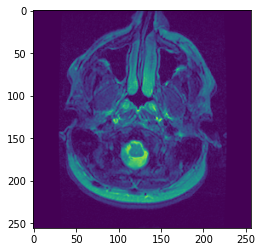

In [10]:
_ = plt.imshow(img)

## 2d Fourier Transform

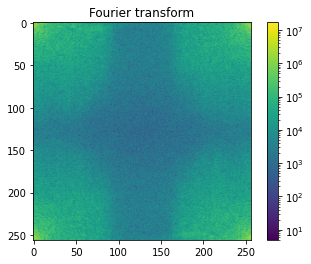

In [11]:
def plot_spectrum(im_fft):
    # A logarithmic colormap
    plt.imshow(np.abs(im_fft), norm=LogNorm(vmin=5))
    plt.colorbar()

im_fft = get_fourier_transform(img, fshift=False, use_absolute=False)
plot_spectrum(im_fft)
_ = plt.title('Fourier transform')

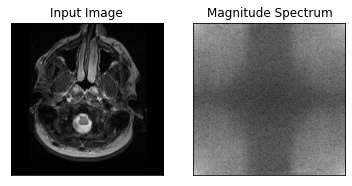

In [13]:
transformed_imgs = [get_fourier_transform(img, use_absolute=True) for img in data.T]

plt.subplot(121), plt.imshow(img, cmap = 'gray');
plt.title('Input Image'), plt.xticks([]), plt.yticks([]);
plt.subplot(122), plt.imshow(transformed_imgs[0], cmap = 'gray');
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([]);
plt.show();

## K-space Spiral Trajectory

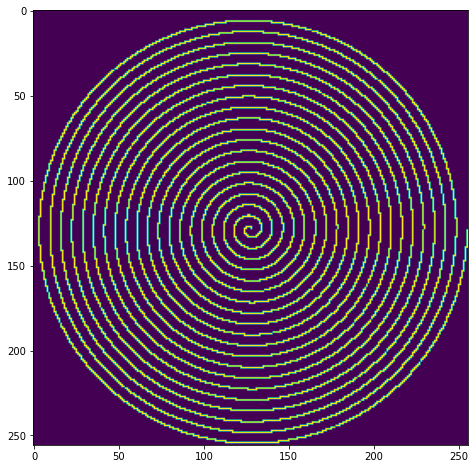

In [14]:
img_size = 256
samples_rows, i, j, I =  spiral_samples_trajectory(width=img_size, height=img_size, n_turns=20)

plt.figure(figsize=(8,8));
plt.imshow(np.fft.fftshift(I));

# Get K Space measurements

In [15]:
measurements = kspace_measurements_spiral(img, samples_rows)
measurements.size

10173

# Reconstruct image with minimum energy algorithm

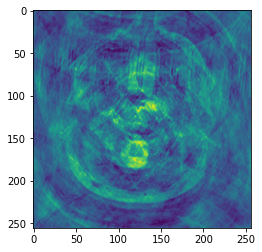

In [16]:
reconstructed_img = minimum_energy_reconstruction(measurements, 256, 256, samples_rows)
plt.imshow(np.abs(reconstructed_img));

In [56]:
N = 512
eta = int(0.1 * N)

def generate_X(N, eta):
    if isinstance(N, int):
        T = np.random.randn(N, N)
    else:
        T = N
        N = T.shape[0]
    
    X_hat = np.zeros((N, 1))
    
    non_zero_indices = np.random.permutation(N)[:eta]
    rand_elements = np.reshape(np.random.randn(eta), [eta, 1])
    
    X_hat[non_zero_indices] = rand_elements
    
    # T^-1 * X_hat
    X = np.linalg.solve(T, X_hat)

    return X, X_hat, non_zero_indices, T

X, X_hat, non_zero_indices, T = generate_X(N, eta)
# X = np.reshape(X, [X.shape[0],])
X.shape

(512, 1)

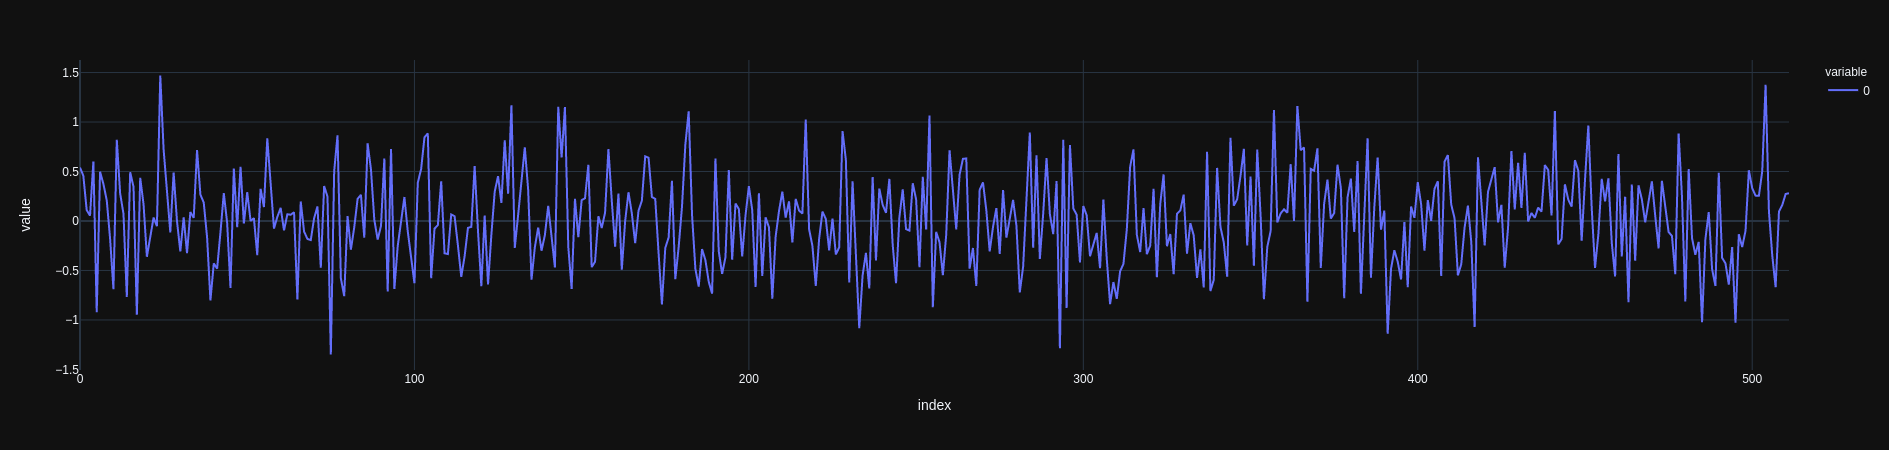

In [51]:
px.line(X)

In [89]:
import importlib
importlib.reload(mri_cs)
def indirect_lpminimization(ell):
    M = np.random.randn(ell, N)
    b = np.dot(M, X)
    # reconstrucao do sinal a partir das medidas
    A = np.dot(M, np.linalg.inv(T))
    Ah = mri_cs.hermitian(A)
    A_ = lambda x: np.dot(A, x)
    Ah_ = lambda x: np.dot(Ah, x)

    X_hat_r = mri_cs.lpminimization(A_, Ah=Ah_, b=b, p=1, N=N)
    return X_hat_r

<module 'mri_cs' from '../src/mri_cs.py'>

In [ ]:
# checar shapes de entrada para direto e 
# indireto e garantir que o return seja igual para os dois

# (512,) ou (512, 1): identificar o melhor

# gerar graficos indireto vs direto em relacao a SER-dB

In [90]:
indi_Xr_h = indirect_lpminimization(int(0.8 * N))
indir_Xr = np.linalg.solve(T, indi_Xr_h)

(512, 1)

(512, 1)

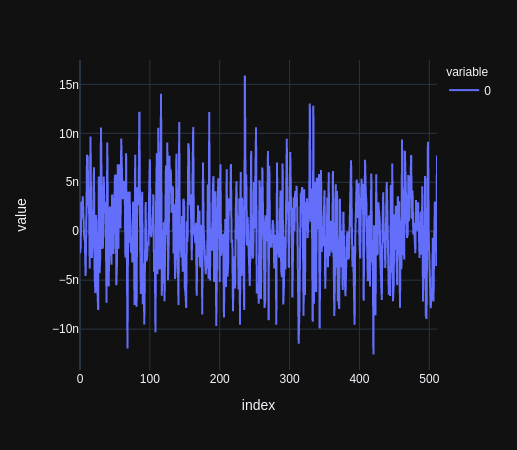

In [92]:
indir_Xr.shape
X.shape
px.line(indir_Xr - X)

In [86]:
import importlib
importlib.reload(mri_cs)
def direct_lpminimization(ell):
    M = np.random.randn(ell, N)
    b = np.dot(M, X)
    # reconstrucao do sinal a partir das medidas
    A = np.dot(M, np.linalg.inv(T))
    
    X_hat_r = mri_cs.lpminimization(A, b=b, p=1)
    return X_hat_r

<module 'mri_cs' from '../src/mri_cs.py'>

In [87]:
dir_Xr_h = direct_lpminimization(int(0.8 * N))
dir_Xr_h.shape
dir_Xr = np.linalg.solve(T, dir_Xr_h)

(512, 1)

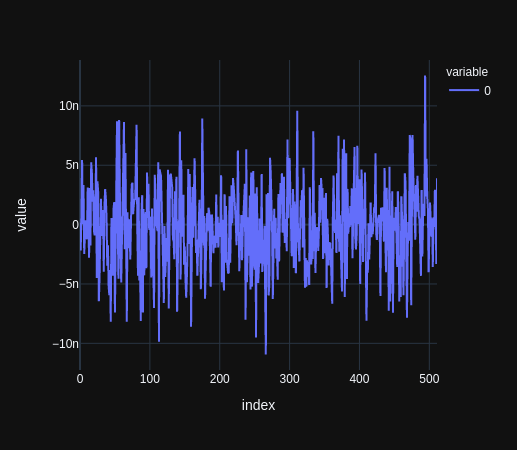

In [88]:
px.line(dir_Xr - X)

In [93]:
ell_tests = np.arange(int(0.1 * N), N, int(0.1 * N))
ell_tests

array([ 51, 102, 153, 204, 255, 306, 357, 408, 459, 510])

In [96]:
import importlib
importlib.reload(mri_cs)

# Fazer Grafico comparando ser_db com numero de medidas 
# direto vs indireto
# norma L2
# relacao = norma(sinal) / norma(ruido)
# relacao sinal x erro: um numero q reflete quao proximos estao. Quanto mais proximos, maior a relacao
# qualidade da reconstrucao
# medidas colhidas para reconstrucao
Xh_r_indirect = []
Xh_r_direct = []

for ell in tqdm(ell_tests):
    Xh_r_indirect.append(indirect_lpminimization(ell))
    Xh_r_direct.append(direct_lpminimization(ell))

<module 'mri_cs' from '../src/mri_cs.py'>

100%|██████████| 10/10 [00:34<00:00,  3.47s/it]


In [ ]:
# testar modos direto e indireto
# construir mesmo grafico para direto e indireto
# direto = explicitamente se usa a matriz. Mais preciso e mais rapido.
# indireto = quando nao eh possivel armazenar a matriz
# lapak. biblioteca
# estrutura do texto semana que vem

In [104]:
def solve_X(X_hat_r):
    Xr = np.linalg.solve(T, X_hat_r)
    return Xr

def calculate_signal_error(X, err):
    # energia: somatorio do modulo ao quadrado
    signal_energy = np.sum(np.abs(X)**2)
    error_energy = np.sum(np.abs(err)**2)
    signal_error_ratio = signal_energy / error_energy
    #  decibel
    ser_db = 10 * np.log10(signal_error_ratio)
#     print(f"Signal Error Ratio: {signal_error_ratio}")
#     print(f"Signal Error Ratio dB: {ser_db}")
    
    return signal_error_ratio, ser_db
    
def plot_signals(Xr, X, err):
    plt.subplot(311);
    plt.plot(Xr, color="red", linestyle="-.");

    plt.subplot(312);
    plt.plot(X, color="blue", linestyle="-.");

    plt.subplot(313);
    plt.plot(err, color="orange", linestyle="-.");

    plt.show()

In [100]:
Xr_indirect = [solve_X(i) for i in tqdm(Xh_r_indirect)]
Xr_direct = [solve_X(i) for i in tqdm(Xh_r_direct)]

100%|██████████| 10/10 [00:00<00:00, 45.81it/s]


In [128]:
indirect_errs = [Xr - X for Xr in tqdm(Xr_indirect)]
direct_errs = [Xr - X for Xr in tqdm(Xr_direct)]

100%|██████████| 10/10 [00:00<00:00, 64035.18it/s]


In [130]:
def plot(ell_tests, ser_db_dir, ser_db_indir):
    fig = go.Figure()
    _ = fig.add_trace(
        go.Scatter(
            x=ell_tests,
            y=ser_db_dir,
            mode='lines+markers',
            name='Direct dB Error '
        ),
    )
    _ = fig.add_trace(
        go.Scatter(
            x=ell_tests,
            y=ser_db_indir,
            mode='lines+markers',
            name='Indirect dB Error '
        )
    )
    _ = fig.update_layout(
        title='Error',
        xaxis_title='L',
        yaxis_title='Signal to Error Ratio in dB')
    fig.show()

In [135]:
ser_indirect = []
ser_direct = []
ser_db_indirect = []
ser_db_direct = []

for Xr_dir, Xr_ind, ind_err, dir_err in zip(Xr_direct, Xr_indirect, indirect_errs, direct_errs):
    ser_dir, ser_db_dir = calculate_signal_error(X, dir_err)
    ser_direct.append(ser_dir)
    ser_db_direct.append(ser_db_dir)
    
    ser_indir, ser_db_indir = calculate_signal_error(X, ind_err)
    ser_indirect.append(ser_db_indir)
    ser_db_indirect.append(ser_db_indir)

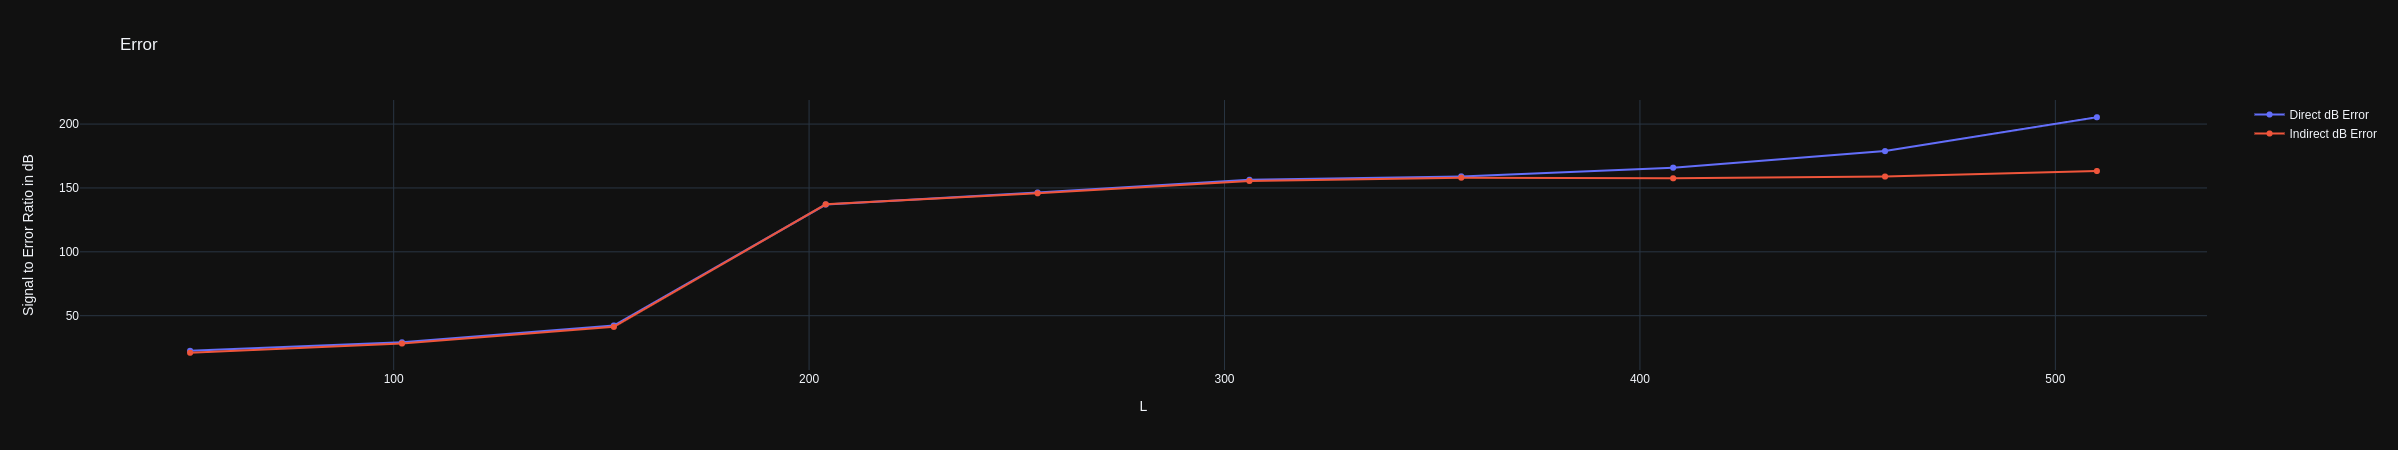

In [134]:
plot(ell_tests, ser_db_direct, ser_db_indirect)